In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName, Motif
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union
import numpy as np
from collections import defaultdict
from isomorphic.isomorphic import get_sub_graph_mapping_to_motif
from post_motif_analysis.network_utils import draw_sub_graph, draw_neighbors, node_properties
from matplotlib.patches import ArrowStyle 
import matplotlib.patches as patches
from networks.network import Network
from numpy import linalg as LA
import plotly.express as px

In [3]:
three_sub_graphs_mapping = {
    14: "mutual out",
    38: "feed forward",
    46: "regulating mutual",
    74: "mutual in",
    78: "bi-mutual",
    102: "mutual cascade",
    108: "regulated mutual",
    110: "semi clique",
    6: "fan out",
    12: "cascade",
    36: "fan in",
    98: "feed backward",
    238: "clique"
}

three_sub_graphs_colors = {
    14: "#1f77b4",
    38: "#ff7f0e",
    46: "#2ca02c",
    74: "#d62728",
    78: "#9467bd",
    102: "#8c564b",
    108: "#e377c2",
    110: "#7f7f7f",
    6: "#bcbd22",
    12: "#17becf",
    36: "red",
    98: "green",
    238: "black"
}

In [4]:
def get_polarity_motifs_list(motifs: dict):
    polarity_motifs = []
    for m in motifs.values():
        polarity_motifs.extend(m.polarity_motifs)
    return polarity_motifs

d1 = import_results('results/pol_k3_m5_nerve_ring.bin')
d2 = import_results('results/pol_k3_m5_nerve_ring_bio_rand.bin')


d1 = import_results('results/pol_k3_m5.bin')
d2 = import_results('results/pol_k3_m5.bin')


motifs1 = d1['motifs']
motifs2 = d2['motifs']

name1 = 'pol_k3_m5_nerve_ring'
name2 = 'pol_k3_m5_nerve_ring_bio_rand'

polarity_motifs1 = get_polarity_motifs_list(motifs1)
polarity_motifs2 = get_polarity_motifs_list(motifs2)

In [12]:
def draw_graph_on_plot(graph, center_x, center_y, range_x, range_y, factor, ax, edge_color, label):
    node_positions = nx.circular_layout(graph)
    for node in node_positions:
        x = node_positions[node][0]
        y = node_positions[node][1]
        
        new_x = x * range_x/factor + center_x
        new_y = y * range_y/factor + center_y
        node_positions[node] = (new_x, new_y)
        
    node_pos = [node_positions[v] for v in graph.nodes()]
    for node, pos in node_positions.items():
        ax.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')  # Node labels
    
    for u, v in graph.edges():
        ax.annotate("", xy=node_positions[v], xytext=node_positions[u],
                    arrowprops=dict(arrowstyle="->", linewidth=1.5, color=edge_color))

    ax.text(pos[0], pos[1]/2, label, fontsize=10, ha='center', va='center') 

def draw_graphs(motifs: dict):
    fig, ax = plt.subplots()
    fig.set_size_inches(13, 3)
    step = 18
    ax.set_ylim(ymin=0, ymax=step)
    ax.set_xlim(xmin=0, xmax=(step+2) * 13)

    range_x = 13 * step
    range_y = 3  * step
    for i, m in enumerate(motifs.values()):
        color = three_sub_graphs_colors[m.id]
        cx = (i+1) * step
        graph = nx.DiGraph(m.role_pattern)
        
        label = three_sub_graphs_mapping[int(m.id)]
        label=m.id
        draw_graph_on_plot(graph, cx, step/2, range_x, range_y, step*1.5, ax, color, label)

Comparing 13 motifs
Comparing 132 motifs


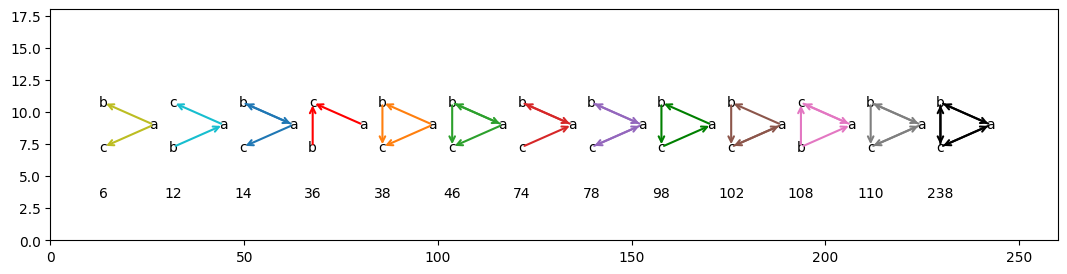

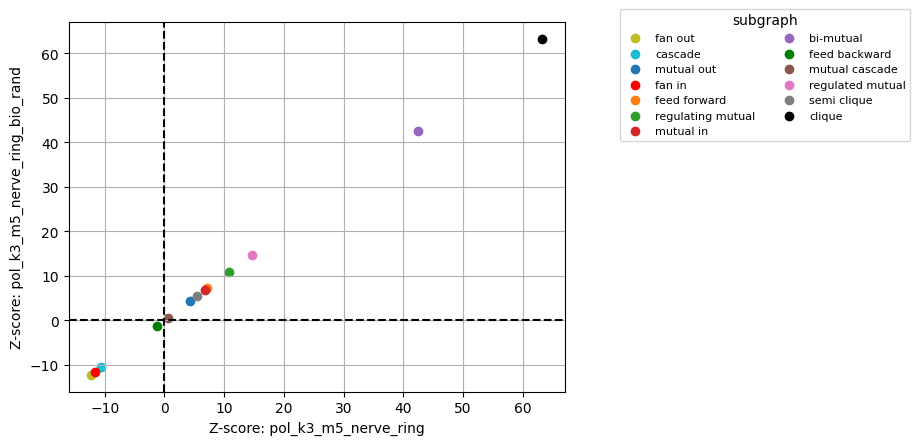

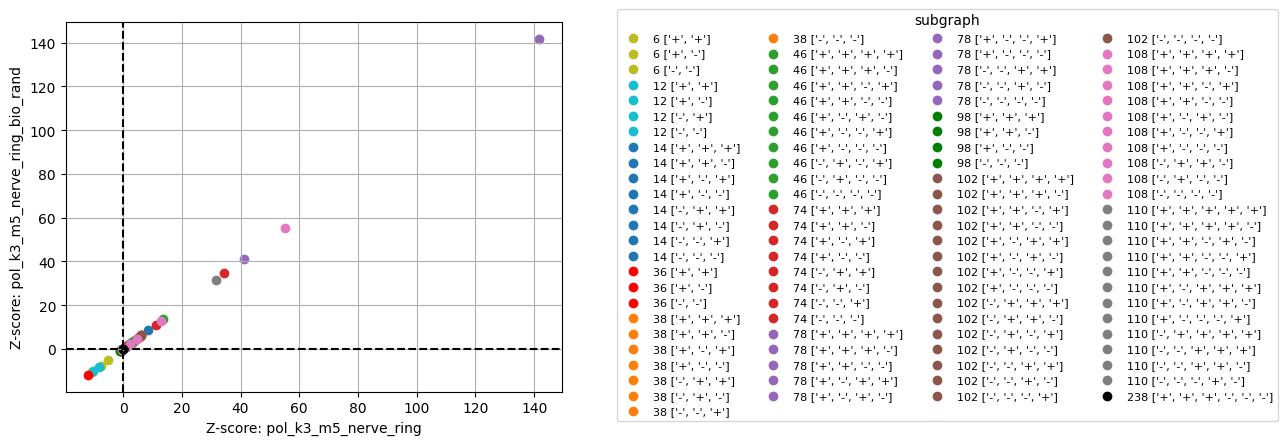

In [14]:
def get_ids(motifs: list[Motif]):
    ids_ = [str(m.id) for m in motifs]
    return [i.replace('complex', 'c') for i in ids_]

def symmetrize_y_axis(axes):
    y_max = np.max(np.abs(axes.get_ylim()))
    axes.set_ylim(ymin=-y_max, ymax=y_max)

def symmetrize_x_axis(axes):
    x_max = np.max(np.abs(axes.get_xlim()))
    axes.set_xlim(xmin=-x_max, xmax=x_max)

def z_score_compare(motifs1: list[Motif], motifs2: list[Motif], use_full_name=False, filter_th=0, norm=True):
    ids1 = get_ids(motifs1)
    ids2 = get_ids(motifs2)
    if not ids2 == ids1:
        print('networks dont match for comparison')
        return
    print(f'Comparing {len(ids1)} motifs')
    
    z_scores1 = [round(m.motif_criteria.z_score, 2) for m in motifs1]
    z_scores2 = [round(m.motif_criteria.z_score, 2) for m in motifs2]

    if norm:
        z_scores1 = np.array(z_scores1) / LA.norm(z_scores1)
        z_scores2 = np.array(z_scores2) / LA.norm(z_scores2)


    colors = []
    for id_ in ids1:
        if use_full_name:
            colors.append(three_sub_graphs_mapping[int(id_)])
        else:
            colors.append(id_)
            
    # fig = px.scatter(x=z_scores1,
    #                  y=z_scores2,
    #                  color=colors,
    #                  labels={
    #                      "x": name1,
    #                      "y": name2
    #                  },
    #                 ).show()
    
    fig, ax = plt.subplots()
    plt.axhline(0, color='black', linestyle ="--")
    plt.axvline(0, color='black', linestyle ="--")

    for i, (id_, z1, z2) in enumerate(zip(ids1, z_scores1, z_scores2)):
        if not norm:
            if abs(z1) <= filter_th and abs(z2) <= filter_th:
                continue
                
        if use_full_name:
            label = three_sub_graphs_mapping[int(id_)]
        else:
            label = id_
            
        id_num = int(id_.split()[0])
        ax.scatter(z1, z2, label=label, color=three_sub_graphs_colors[id_num])
        
    legend_cols = 2 if len(ids1) < 100 else 4
    lgd = ax.legend(loc='best', ncol=legend_cols, title="subgraph", fontsize=8, bbox_to_anchor=(1.1, 1.05))
    ax.grid(True)
    
    plt.ylabel(f'Z-score: {name2}')
    plt.xlabel(f'Z-score: {name1}')

    # symmetrize_y_axis(ax)
    # symmetrize_x_axis(ax)


draw_graphs(motifs1)
z_score_compare(list(motifs1.values()), list(motifs2.values()), use_full_name=True, filter_th=0, norm=False)
z_score_compare(polarity_motifs1, polarity_motifs2, use_full_name=False, filter_th=0.0, norm=False)